In [1]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [2]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring data into a dataframe 

In [3]:
def fill_empty_track(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    list_names = ["X_track", "Y_track", "Z_track", "vx_track", "vy_track", 
                  "vz_track", "track_id", "obj_type", "track_status"]
    
    returndf[list_names] = np.nan
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf
    
def fill_empty_detection(tracks, returndf):
    
    coord_tracks = [np.array(vals[1].tolist()) for vals in tracks]   
    coord_tracks = np.vstack(coord_tracks)
        
    vel_tracks = [np.array(vals[2].tolist()) for vals in tracks]
    vel_tracks = np.vstack(vel_tracks)
        
    track_id = [vals[0].tolist() for vals in tracks]
    object_type = [vals[3] for vals in tracks]
    status_tracks = [vals[4] for vals in tracks]
        
    returndf["X_track"] = coord_tracks[:,0]
    returndf["Y_track"] = coord_tracks[:,1]
    returndf["Z_track"] = coord_tracks[:,2]

    returndf["vx_track"] = vel_tracks[:,0]
    returndf["vy_track"] = vel_tracks[:,1]
    returndf["vz_track"] = vel_tracks[:,2]

    returndf["track_id"] = track_id
    returndf["obj_type"] = object_type
    returndf["track_status"] = status_tracks
    
    list_names = ["X_box", "Y_box", "Z_box", "length_box", "width_box", 
                  "height_box", "angle_box"]
    
    returndf[list_names] = np.nan
    
    return returndf
    
def link_detections_tracks_NN(detections, tracks, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_tracks = [np.array(vals[1].tolist()) for vals in tracks]

    
    if coord_tracks and coord_detections:
        
        vel_tracks = [np.array(vals[2].tolist()) for vals in tracks]
        track_id = [vals[0].tolist() for vals in tracks]
        object_type = [vals[3] for vals in tracks]
        status_tracks = [vals[4] for vals in tracks]
    
    # for the time being, let us associate the closest bounding box, even if it is assigned more than once
    
        dists = cdist(coord_tracks, coord_detections, 'euclidean')
#     print(dists)
        associations = np.argmin(dists, axis=1)
    
        associations = associations.tolist()
        associated_detections = [detections[i] for i in associations]
        coord_detections = [coord_detections[i] for i in associations]
        length_box = [vals[1] for vals in associated_detections]
        width_box = [vals[2] for vals in associated_detections]
        height_box = [vals[3] for vals in associated_detections]
        angle_box = [vals[4] for vals in associated_detections]
    
        coord_detections = np.vstack(coord_detections)
        coord_tracks = np.vstack(coord_tracks)
        vel_tracks = np.vstack(vel_tracks)
        returndf["X_track"] = coord_tracks[:,0]
        returndf["Y_track"] = coord_tracks[:,1]
        returndf["Z_track"] = coord_tracks[:,2]

        returndf["vx_track"] = vel_tracks[:,0]
        returndf["vy_track"] = vel_tracks[:,1]
        returndf["vz_track"] = vel_tracks[:,2]
        returndf["track_id"] = track_id
        returndf["obj_type"] = object_type
        returndf["track_status"] = status_tracks
        
        returndf["X_box"] = coord_detections[:,0]
        returndf["Y_box"] = coord_detections[:,1]
        returndf["Z_box"] = coord_detections[:,2]
        returndf["length_box"] = length_box
        returndf["width_box"] = width_box
        returndf["height_box"] = height_box
        returndf["angle_box"] = angle_box

    return returndf

In [4]:
def h5_to_df(h5data, camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        track = np.asarray(d['Tracks'])
        detection = np.asarray(d['Detections'])
        
        if detection.size and track.size:
            append_df = link_detections_tracks_NN(detection, track, append_df)
        
        elif detection.size:
            fill_empty_track(detection, append_df)
        
        elif track.size:
            fill_empty_detection(track, append_df)
            
        append_df['timestamp'] = t
        append_df['frame'] = c
        
        if camera is not None:
            append_df['camera'] = camera
        
        df = df.append(append_df)
        
    return df

In [5]:
df_109 = h5_to_df(hdf5data_109)
df_109.reset_index(inplace=True, drop=True)
df_130 = h5_to_df(hdf5data_130)
df_130.reset_index(inplace=True, drop=True)
df_142 = h5_to_df(hdf5data_142)
df_142.reset_index(inplace=True, drop=True)
df_143 = h5_to_df(hdf5data_143)
df_143.reset_index(inplace=True, drop=True)

## Frame visualization

In [6]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return

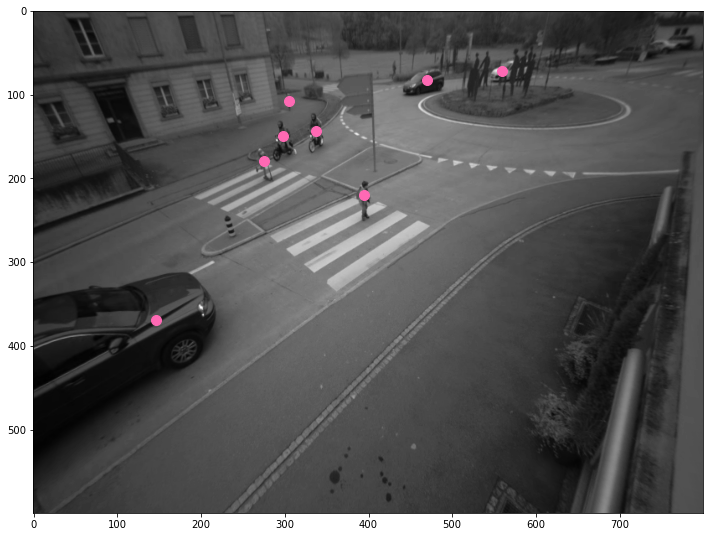

In [7]:
visualize_frame_detections(hdf5data_109,260, figsize = (12,12))

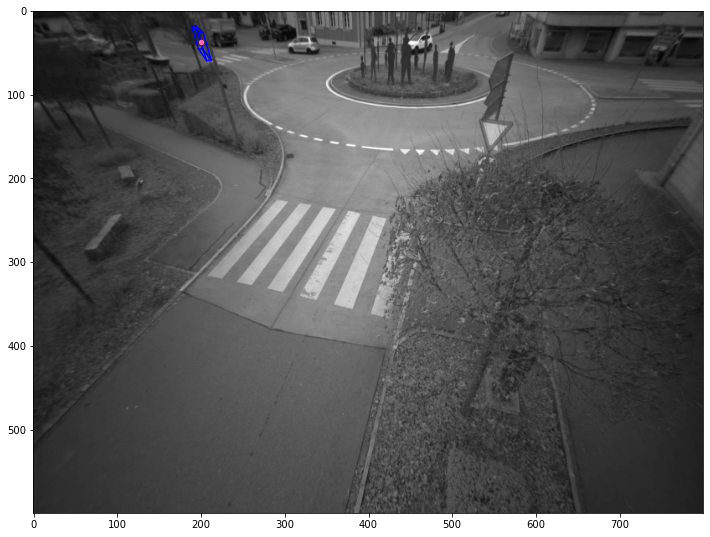

In [70]:
visualize_frame_boxes(hdf5data_142, 730, figsize = (12,12), s = 20)

In [101]:
def plot_trajectory( dataframe, traj_id):
    
    x = dataframe['X_box'][(dataframe['track_id'] == traj_id) & (dataframe['track_status'] == 2)]
    y = dataframe['Y_box'][(dataframe['track_id'] == traj_id) & (dataframe['track_status'] == 2)]

    plt.scatter(x,y)
    
    return

## Top Visualization

In [77]:
df_109[df_109['track_id'] == 799]

,X_track,Y_track,Z_track,vx_track,vy_track,vz_track,track_id,obj_type,track_status,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame
2,-9.613478,18.832103,-1.370161,-0.963250,-1.160499,-0.050569,799,4,2,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0
7,-9.636033,18.814184,-1.377126,-0.851770,-1.007756,-0.052349,799,4,2,-9.487168,19.018149,-1.403667,2.751621,1.204600,1.533254,-0.508305,1.574333e+09,1
12,-9.640875,18.783817,-1.377759,-0.725849,-0.907823,-0.050125,799,4,2,-9.471875,18.917938,-1.344490,2.740135,1.523416,1.553007,-0.697685,1.574333e+09,2
17,-9.557286,18.680550,-1.379188,-0.444262,-0.969208,-0.048515,799,4,2,-9.183624,18.597415,-1.355930,1.283514,0.745171,1.878356,0.409065,1.574333e+09,3
22,-9.499359,18.570667,-1.381791,-0.258765,-1.035506,-0.047743,799,4,2,-9.246327,18.480157,-1.370194,1.436779,0.704693,1.725794,0.366784,1.574333e+09,4
26,-9.447949,18.459825,-1.383639,-0.114918,-1.091776,-0.046514,799,4,2,-9.251641,18.383025,-1.365100,1.253955,0.661718,1.629647,0.235827,1.574333e+09,5
30,-9.437455,18.325067,-1.385329,-0.075237,-1.182732,-0.045191,799,4,2,-9.383795,18.202067,-1.365403,1.234077,0.617000,1.686681,0.225427,1.574333e+09,6
34,-9.404555,18.210887,-1.386205,0.002159,-1.225910,-0.043524,799,4,2,-9.299302,18.152167,-1.361036,1.230536,0.588501,1.851735,0.202899,1.574333e+09,7
37,-9.416066,18.082092,-1.386562,-0.021146,-1.284481,-0.041536,799,4,2,-9.447539,18.002991,-1.356579,1.319826,0.654763,1.966696,0.403460,1.574333e+09,8
41,-9.424739,17.961535,-1.397198,-0.035091,-1.321883,-0.046139,799,4,2,-9.443646,17.910826,-1.466725,1.231907,0.696082,1.644936,0.357000,1.574333e+09,9


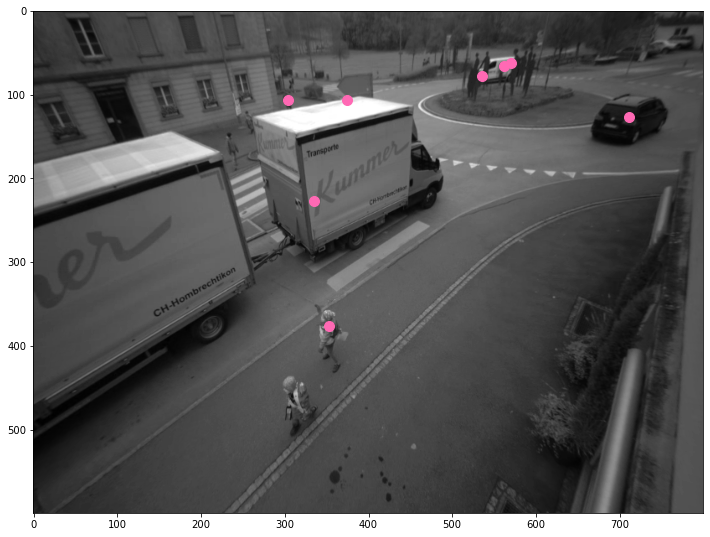

In [76]:
visualize_frame_detections(hdf5data_109, 45, figsize = (12,12))

In [60]:
np.asarray(hdf5data_109['Sequence']['82']['Tracks'])

array([(779, (  6.90995296, 27.89009555, -0.84522417), ( 0.13958117,  0.45637535, 1.35172464e-04),  4, 2),
       (798, (-15.74185682, 11.62591418, -1.35744674), (-1.22348521, -1.01938463, 5.74602694e-03),  4, 2),
       (805, ( -0.43316059, 22.91182051, -0.90367496), ( 1.99957348,  0.2419268 , 5.12883358e-02),  4, 2),
       (817, ( -5.86553577,  7.30196203, -1.28682815), ( 2.43669704,  5.57382058, 2.50098527e-01), 18, 2),
       (821, (  7.42138632, 11.02207693, -1.52573743), ( 1.73525065, -5.46081026, 2.23714831e-01), 34, 2),
       (822, ( -9.58236576, 20.38467142, -1.1174785 ), ( 0.16259129,  0.56722008, 1.00647653e-01),  4, 2)],
      dtype=[('TrackId', '<i8'), ('Pos', [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]), ('Vel', [('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]), ('ClassId', '<u4'), ('Status', '<i4')])

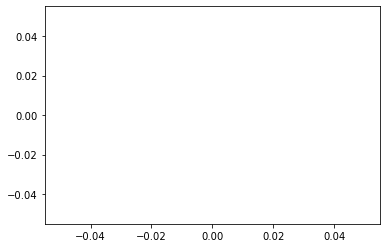

In [105]:
plot_trajectory(df_109, 811)

In [10]:
offline = h5py.File('../../Data/Koelliken_OfflineTracks_Complete_11-21-201911454711-21-2019114647.h5', 'r')

In [40]:
np.array(offline['Tracks']['0']['Detections']['Z_local_coordinate_system'])

array([-0.89696155, -0.89235397,  1.7805324 ,  1.7064141 ,  1.8072656 ,
        1.8792303 ,  1.9769292 , -0.87906239, -0.82266621,  0.63965577,
       -0.75808958, -0.68876109, -0.67635646, -0.55752557, -0.58499093,
       -0.53827597, -0.47562961])

# Classes

In [ ]:
# Obj = { 'x' : 1, 'y': 1, 'z': 1, 'l': 10, 'w': 10, 'h' : 10, 'angle' : np.pi/2}

deltaT = 0.08
threshold = 5

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = threshold):
        self.ID = ID
        self.status = 'Pending'  #Pending, Active, Inactive
        self.objects = [OBJ]
        self.frames = [FRAME]
        self.velocity = []
        self.type = None
        self.threshold = threshold
    
    def compute_vel ( self, OBJ ): #TO DO WITH KALMAN FILTERS NOT THIS SH*T
        vx = (OBJ['x'] - self.objects[-1]['x'])/deltaT
        vy = (OBJ['y'] - self.objects[-1]['y'])/deltaT
        vz = (OBJ['z'] - self.objects[-1]['z'])/deltaT
        
        self.velocity.append((vx,vy, vz))
        
        return
    
    def set_type( self, TYPE ):
        self.type = TYPE
        set_threshold()
        return
    
    def set_threshold (self):
        
        if type = 'car':
            self.threshold = 3
        
        else:
            self.threshold = 10
            
        return
    

In [ ]:
class Analyzer:
    def __init__(self, FRAME):
        self.frame = FRAME
        self.previous_tracks = None
        self.tracks = None
    
    def 